In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from functools import partial

In [2]:
batch_size = 10

mnist = tf.contrib.learn.datasets.load_dataset("mnist")
inputs = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)
x = tf.reshape(inputs, [batch_size, 28, 28, 1])
x = tf.cast(x, tf.complex64)

def complex_random(init):
    def func(shape, dtype=None, partition_info=None):
        real = init(dtype=tf.float32, shape=shape)
        imag = init(dtype=tf.float32, shape=shape)
        return tf.complex(real, imag)
    return func

def mri(x):
    y = tf.fft2d(x)
    
    init_fn = partial(tf.random_uniform, minval=0, maxval=1)
    sub_sampler = complex_random(init_fn)(y.shape)
    y *= sub_sampler
    y += complex_random(tf.random_normal)(y.shape)
    return y

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
y = mri(x)
y

<tf.Tensor 'add:0' shape=(10, 28, 28, 1) dtype=complex64>

# [Recurrent inference machines](https://openreview.net/forum?id=HkSOlP9lg)



In [4]:
def dydx(y, x, sigma=1.0):
    # TODO want to verify this for myself.
    z = tf.fft(x)  # TODO add mask
    return tf.ifft2d(z-y)/(sigma**2)

In [33]:
class RIM(tf.keras.Model):
    def __init__(self, dydx, units=24):
        """
        Args:
            dydx (func): the gradient of y w.r.t the mri fn
        """
        super(self.__class__, self).__init__(self)
        self.units = units
        self.construct()
        
    def construct(self):
        """
        Constructs:
            encoder (tf.Model): a parameterised model that updates the state of the RIM
            decoder (tf.Model): a parameterised model that updates our candidate image, x.
        """
        # tf.keras.Sequential(
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Conv2D(8, 4, strides=(2, 2), padding='same'),
            tf.keras.layers.Activation(tf.keras.activations.selu),
            tf.keras.layers.Conv2D(8, 4, strides=(2, 2), padding='same'),
        ])
        self.dcnn = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(1, 4, strides=(2, 2), padding='same'),
            tf.keras.layers.Activation(tf.keras.activations.selu),
            tf.keras.layers.Conv2DTranspose(1, 4, strides=(2, 2), padding='same')
        ])
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.units))

    def call(self, y, iters=10):
        """
        Args:
            y (tf.tensor): the k-space samples

        """
        # TODO how is this trained with big images!? not possible!? 
        # the recurrent dependencies will use up lots of memory!!
        
        x_t = tf.ifft2d(y)  # init x_0

        state = tf.zeros(shape=[y.shape[0], self.units], dtype=tf.float32)
        # for loop or rnn loop or while loop?
        for i in range(iters):
            g = dydx(y, x_t)

            g_e = self.embed(g)
            x_t_e = self.embed(x_t)
            
            state = self.encoder(g_e, x_t_e, state)
            x_t += self.decoder(g_e, x_t_e, state)

        # why not just a big rnn?
        # ah. because we want to calculate dydx for each x_t
        # x_t = rnn(dydx!?!, ...)

        return x_t
    
    def embed(self, x):
        x = tf.cast(x, tf.float32)
        x = self.cnn(x)
        self.shape = x.shape
        return tf.reshape(x, (x.shape[0], -1))
    
    def encoder(self, g, x_t, state):
        x = tf.concat([g, x_t], axis=-1)
        x = tf.reshape(x, [x_t.shape[0], 1, -1])
        
        y = self.rnn(x, state)
        return y

    def decoder(self, g, x_t, state):
        g = tf.reshape(g, self.shape)
        x_t = tf.reshape(x_t, self.shape)
        x = tf.concat([g, x_t], axis=-1)
        y = self.dcnn(x)
        y = tf.cast(y, tf.complex64)
        return y

In [34]:
rim = RIM(dydx)
x_t = rim(y)

In [35]:
loss = tf.losses.mean_squared_error(x, x_t)
opt = tf.train.AdamOptimizer()
train_step = opt.minimize(loss)

In [36]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

          

In [37]:
for i in range(100):
    idx = np.random.randint(0, len(mnist.train.images), 10)
    sess.run(train_step, feed_dict={inputs: mnist.train.images[idx, ...]})


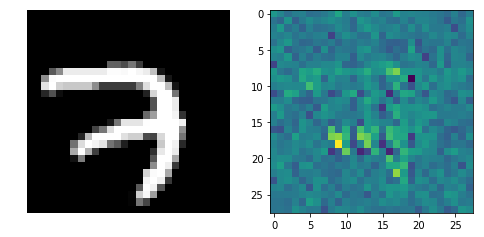

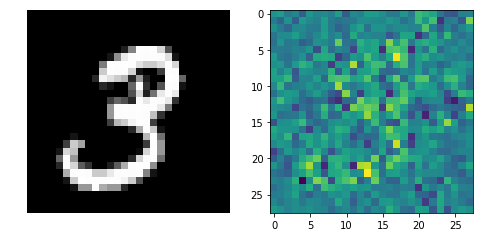

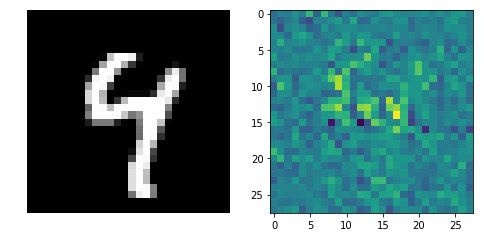

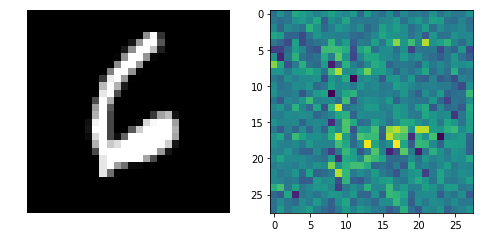

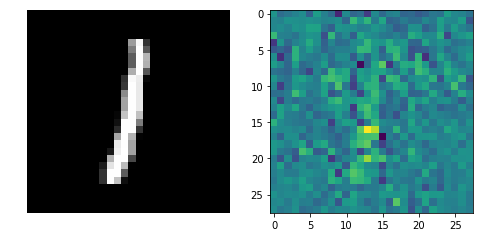

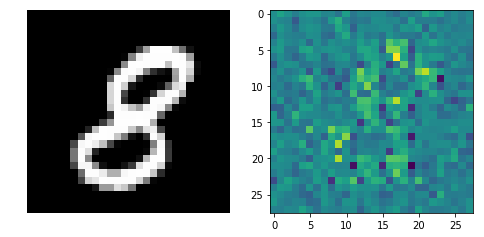

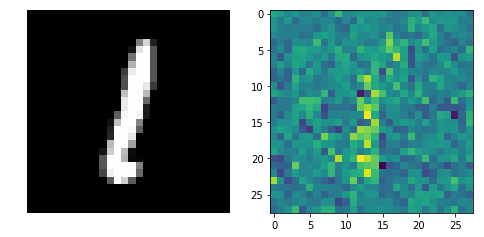

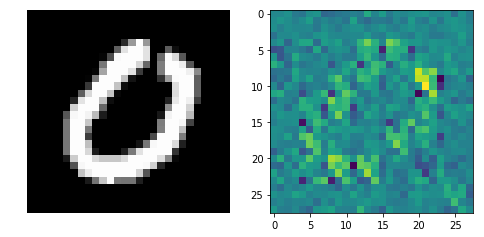

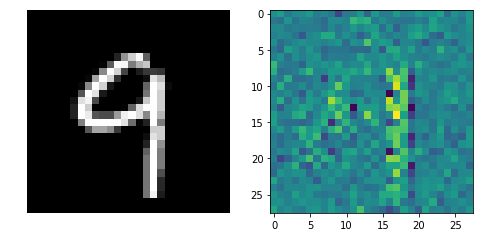

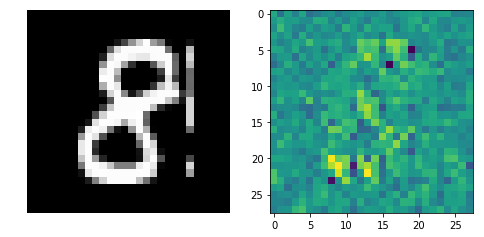

In [17]:
X = sess.run(x_t, feed_dict={inputs: mnist.train.images[0:10]})
for i in range(batch_size):
    fig = plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mnist.train.images[i, ...].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(np.real(X[i]).reshape((28, 28)))